In [1]:
import pandas as pd
import utils_max_flow as utils
import pickle

In [2]:
with open('graph_objects/G_simple_directed_iggielgn.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

In [3]:
# Dataset; 'iggin' or 'iggielgn'
dataset = 'iggin'

# S-t-flow; 's-t-degree' or 's-t-type'
s_t_flow = 's-t-degree'

In [4]:
# Toggle to run N-k or just print stored results
run_analysis = False

----
# Heuristics

### Node removal

In [5]:
if run_analysis:
    random_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='random', remove='node', sinks_sources='degree', n_benchmarks=3)
    random_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_node_removal_df.pkl')
random_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_node_removal_df.pkl')

In [6]:
if run_analysis:
    load_rate_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='node', sinks_sources='degree')
    load_rate_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_node_removal_df.pkl')
load_rate_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_node_removal_df.pkl')
utils.results_summary(load_rate_node_removal_df)

Heuristic: load_rate

First entity removals:
----------------------------------------------
 it removed_entity    diff  pct_change
  1         NO_N_4 1583.12        -7.7
  2    INET_N_1333 3218.48       -16.9
  3    INET_N_1545 2252.88       -14.2
  4    INET_N_1219 2190.12       -16.1
  5    INET_N_1113  234.00        -2.1

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity    diff  pct_change
  2    INET_N_1333 3218.48       -16.9
  3    INET_N_1545 2252.88       -14.2
  4    INET_N_1219 2190.12       -16.1
  1         NO_N_4 1583.12        -7.7
  7     INET_N_279  752.27        -7.2


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 1999.37
Variation in damage per entity removal: 910.41
The metric reaches 0 at iteration 89.


In [7]:
if run_analysis:
    max_flow_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='node', sinks_sources='degree')
    max_flow_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_node_removal_df.pkl')
max_flow_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_node_removal_df.pkl')
utils.results_summary(max_flow_node_removal_df)

Heuristic: max_flow_edge_flows

First entity removals:
----------------------------------------------
 it removed_entity    diff  pct_change
  1        NO_N_16 1818.72        -8.8
  2    INET_N_1035 3218.48       -17.1
  3    INET_N_1545 2252.88       -14.5
  4     INET_N_435 2189.31       -16.4
  5     INET_N_741  982.86        -8.8

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity    diff  pct_change
  2    INET_N_1035 3218.48       -17.1
  3    INET_N_1545 2252.88       -14.5
  4     INET_N_435 2189.31       -16.4
  1        NO_N_16 1818.72        -8.8
  5     INET_N_741  982.86        -8.8


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 2092.45
Variation in damage per entity removal: 807.65
The metric reaches 0 at iteration 93.


In [8]:
if run_analysis:
    max_flow_edge_count_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='node', sinks_sources='degree')
    max_flow_edge_count_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_node_removal_df.pkl')
max_flow_edge_count_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_node_removal_df.pkl')
utils.results_summary(max_flow_edge_count_node_removal_df)

Heuristic: max_flow_edge_count

First entity removals:
----------------------------------------------
 it removed_entity    diff  pct_change
  1        NO_N_16 1818.72        -8.8
  2    INET_N_1035 3218.48       -17.1
  3    INET_N_1219 2190.12       -14.0
  4    INET_N_1545 2252.88       -16.8
  5     INET_N_741 1026.74        -9.2

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity    diff  pct_change
  2    INET_N_1035 3218.48       -17.1
  4    INET_N_1545 2252.88       -16.8
  3    INET_N_1219 2190.12       -14.0
  1        NO_N_16 1818.72        -8.8
  5     INET_N_741 1026.74        -9.2


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 2101.39
Variation in damage per entity removal: 792.7
The metric reaches 0 at iteration 92.


In [9]:
if run_analysis:
    wfcr_node_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='node', sinks_sources='degree')
    wfcr_node_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_node_removal_df.pkl')
wfcr_node_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_node_removal_df.pkl')
utils.results_summary(wfcr_node_removal_df)

Heuristic: wfcr

First entity removals:
----------------------------------------------
 it removed_entity    diff  pct_change
  1         NO_N_4 1583.12        -7.7
  2    INET_N_1637 3218.48       -16.9
  3    INET_N_1545 2252.88       -14.2
  4    INET_N_1219 2190.12       -16.1
  5     INET_N_279  752.27        -6.6

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity    diff  pct_change
  2    INET_N_1637 3218.48       -16.9
  3    INET_N_1545 2252.88       -14.2
  4    INET_N_1219 2190.12       -16.1
  1         NO_N_4 1583.12        -7.7
  6    INET_N_1215  772.94        -7.3


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 2003.51
Variation in damage per entity removal: 903.35
The metric reaches 0 at iteration 95.


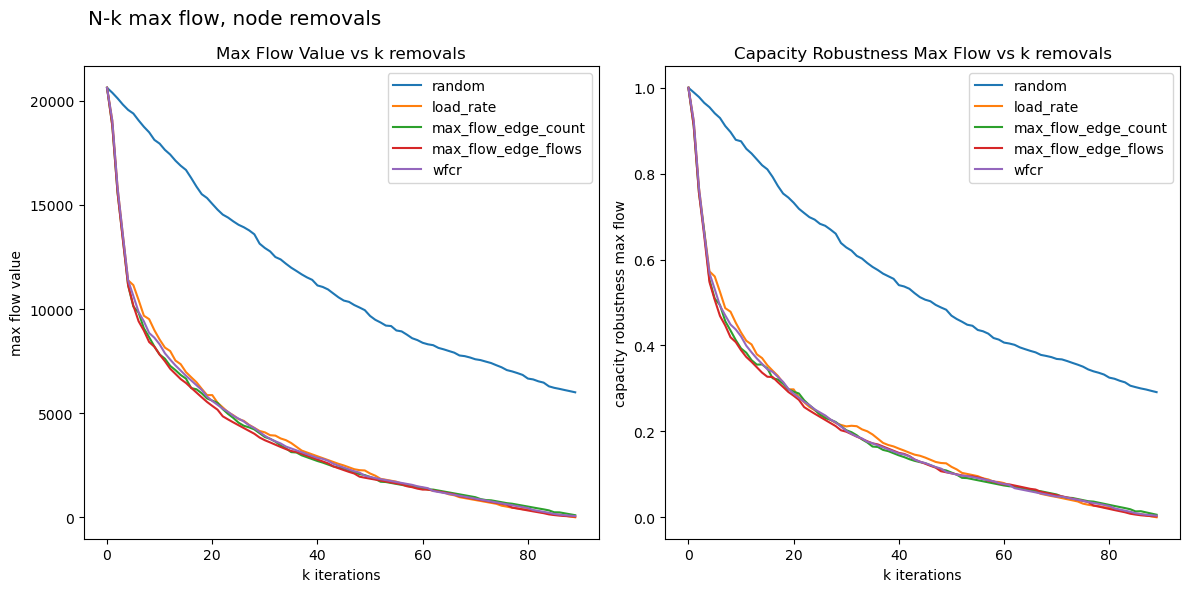

In [10]:
fig = utils.plot_heuristic_comparison_biplot([random_node_removal_df, load_rate_node_removal_df, max_flow_edge_count_node_removal_df, max_flow_node_removal_df, wfcr_node_removal_df], 'N-k max flow, node removals')
fig.savefig('saved_plots/'+dataset+'/'+s_t_flow+'/max_flow/node_removals.png')

### Edge removal

In [11]:
if run_analysis:
    random_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='random', remove='edge')
    random_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl')
random_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/random_edge_removal_df.pkl')

In [12]:
if run_analysis:
    load_rate_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='edge', sinks_sources='degree')
    load_rate_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_edge_removal_df.pkl')
load_rate_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/load_rate_edge_removal_df.pkl')
utils.results_summary(load_rate_edge_removal_df) 

Heuristic: load_rate

First entity removals:
----------------------------------------------
 it             removed_entity    diff  pct_change
  1           {NO_N_5, NO_N_4} 1583.12        -7.7
  2 {INET_N_1637, INET_N_1035} 3218.48       -16.9
  3  {INET_N_151, INET_N_1545} 2136.99       -13.5
  4  {INET_N_1219, INET_N_870} 1703.37       -12.4
  5  {INET_N_698, INET_N_1113}  189.36        -1.6

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity    diff  pct_change
  2 {INET_N_1637, INET_N_1035} 3218.48       -16.9
  3  {INET_N_151, INET_N_1545} 2136.99       -13.5
  4  {INET_N_1219, INET_N_870} 1703.37       -12.4
  1           {NO_N_5, NO_N_4} 1583.12        -7.7
  8  {INET_N_279, INET_N_1000}  752.27        -7.0


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 1878.85
Variation in damage 

In [13]:
if run_analysis:
    max_flow_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='edge', sinks_sources='degree')
    max_flow_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_removal_df.pkl')
max_flow_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_removal_df)

Heuristic: max_flow_edge_flows

First entity removals:
----------------------------------------------
 it             removed_entity    diff  pct_change
  1          {NO_N_4, NO_N_16} 1583.12        -7.7
  2 {INET_N_1637, INET_N_1620} 3218.48       -16.9
  3  {INET_N_151, INET_N_1545} 2136.99       -13.5
  4  {INET_N_1219, INET_N_435} 1761.47       -12.9
  5  {INET_N_1199, INET_N_741}  969.98        -8.1

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity    diff  pct_change
  2 {INET_N_1637, INET_N_1620} 3218.48       -16.9
  3  {INET_N_151, INET_N_1545} 2136.99       -13.5
  4  {INET_N_1219, INET_N_435} 1761.47       -12.9
  1          {NO_N_4, NO_N_16} 1583.12        -7.7
  5  {INET_N_1199, INET_N_741}  969.98        -8.1


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 1934.01
Variation 

In [14]:
if run_analysis:
    max_flow_edge_count_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge', sinks_sources='degree')
    max_flow_edge_count_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_edge_removal_df.pkl')
max_flow_edge_count_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/max_flow_edge_count_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_count_edge_removal_df)

Heuristic: max_flow_edge_count

First entity removals:
----------------------------------------------
 it             removed_entity    diff  pct_change
  1          {NO_N_4, NO_N_16} 1583.12        -7.7
  2 {INET_N_1637, INET_N_1035} 3218.48       -16.9
  3  {INET_N_1219, INET_N_870} 1703.37       -10.8
  4  {INET_N_151, INET_N_1545} 2136.99       -15.1
  5  {INET_N_1199, INET_N_741} 1013.87        -8.5

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity    diff  pct_change
  2 {INET_N_1637, INET_N_1035} 3218.48       -16.9
  4  {INET_N_151, INET_N_1545} 2136.99       -15.1
  3  {INET_N_1219, INET_N_870} 1703.37       -10.8
  1          {NO_N_4, NO_N_16} 1583.12        -7.7
  5  {INET_N_1199, INET_N_741} 1013.87        -8.5


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 1931.17
Variation 

In [15]:
if run_analysis:
    wfcr_edge_removal_df = utils.flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='edge', sinks_sources='degree')
    wfcr_edge_removal_df.to_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_edge_removal_df.pkl')
wfcr_edge_removal_df = pd.read_pickle('results/max_flow/'+dataset+'/'+s_t_flow+'/wfcr_edge_removal_df.pkl')
utils.results_summary(wfcr_edge_removal_df) 

Heuristic: wfcr

First entity removals:
----------------------------------------------
 it             removed_entity    diff  pct_change
  1           {NO_N_5, NO_N_4} 1583.12        -7.7
  2 {INET_N_1637, INET_N_1620} 3218.48       -16.9
  3  {INET_N_151, INET_N_1545} 2136.99       -13.5
  4  {INET_N_1219, INET_N_870} 1703.37       -12.4
  5  {INET_N_279, INET_N_1000}  752.27        -6.3

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity    diff  pct_change
  2 {INET_N_1637, INET_N_1620} 3218.48       -16.9
  3  {INET_N_151, INET_N_1545} 2136.99       -13.5
  4  {INET_N_1219, INET_N_870} 1703.37       -12.4
  1           {NO_N_5, NO_N_4} 1583.12        -7.7
  6  {INET_N_1215, INET_N_891}  772.94        -6.9


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 100.0%
Mean damage per entity removal: 1882.98
Variation in damage per e

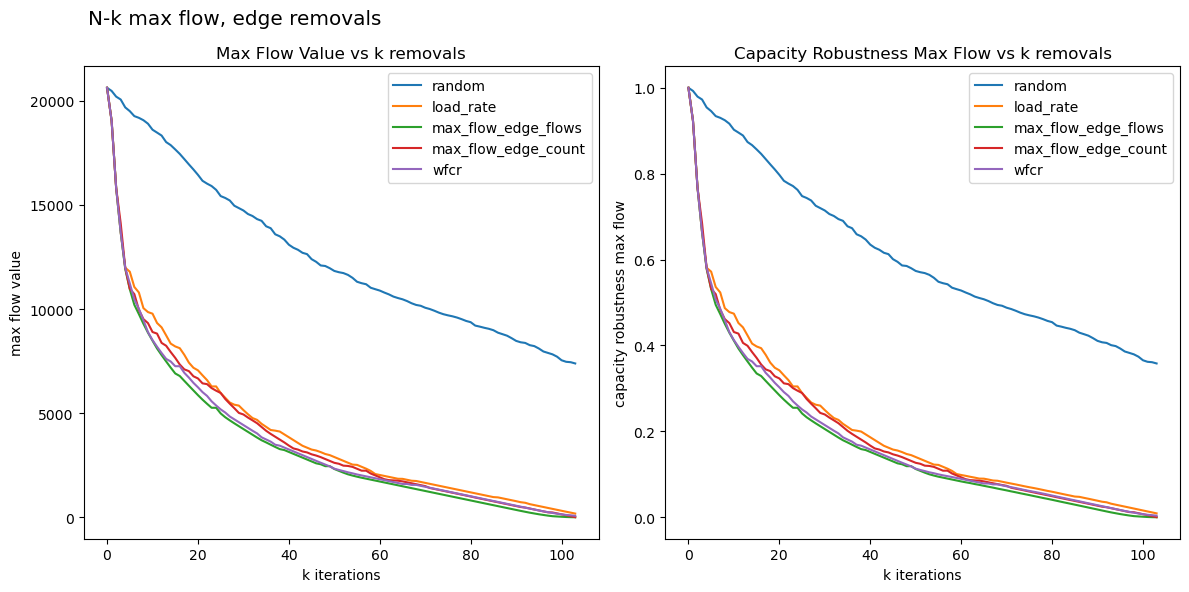

In [16]:
fig = utils.plot_heuristic_comparison_biplot([random_edge_removal_df, load_rate_edge_removal_df, max_flow_edge_removal_df, max_flow_edge_count_edge_removal_df, wfcr_edge_removal_df], 'N-k max flow, edge removals')
fig.savefig('saved_plots/'+dataset+'/'+s_t_flow+'/max_flow/edge_removals.png')